# Neural Network Training Dynamics: Unified Analysis with Opposing Signals Detection

This unified notebook combines and improves upon the previous versions to provide:
- **Robust opposing signal detection** with improved algorithms
- **Example learning and forgetting patterns** analysis
- **High-quality animations** with proper temporal sampling
- **Feature learning dynamics** in CNNs
- **Class-wise analysis** and difficulty tracking
- **Loss trajectory analysis** for individual examples

**Key papers implemented:**
- Rosenfeld & Risteski (2023): Outliers with Opposing Signals
- Toneva et al. (2019): An Empirical Study of Example Forgetting
- Arpit et al. (2017): A Closer Look at Memorization in Deep Networks

**Improvements over previous versions:**
- Fixed opposing pairs detection algorithm
- Better gradient-based analysis
- Unified visualization pipeline
- More robust statistical analysis
- Configurable animation parameters

In [1]:
DATA_PATH = 'C:\\Users\\mateu\\phd\\data'  # Change this to your desired data path

In [2]:
# Configuration
DATA_PATH = DATA_PATH  # Change this to your desired data path
SAVE_ANIMATIONS = True  # Set to False to skip animation generation for faster runs
DENSE_SAMPLING = True   # Set to False for less frequent data collection
OPPOSING_THRESHOLD = 2.0  # Threshold for detecting opposing signals (gradient cosine similarity)
N_EXAMPLES_TRACK = 100    # Number of examples to track in detail
ANIMATION_FPS = 10        # Frames per second for animations

In [3]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
import seaborn as sns

from collections import defaultdict, deque
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import os
import pickle
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

c:\Users\mateu\miniconda3\envs\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## 1. Model Definition and Data Loading

In [4]:
class SimpleCNN(nn.Module):
    """Simple CNN for CIFAR-10 classification with feature extraction capabilities"""
    
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)
        
        # Pooling and dropout
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x, return_features=False):
        # Feature extraction
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten
        x = x.view(-1, 64 * 4 * 4)
        
        # Fully connected layers
        features = F.relu(self.fc1(x))
        features = self.dropout(features)
        output = self.fc2(features)
        
        if return_features:
            return output, features
        return output

# Load CIFAR-10 dataset
def load_cifar10_data(batch_size=64, num_workers=2):
    """Load CIFAR-10 with appropriate transforms"""
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=DATA_PATH, train=True, download=True, transform=transform_train
    )
    
    testset = torchvision.datasets.CIFAR10(
        root=DATA_PATH, train=False, download=True, transform=transform_test
    )

    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers
    )
    
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )

    return trainloader, testloader, trainset, testset

# Load data
trainloader, testloader, trainset, testset = load_cifar10_data()
print(f'Training set size: {len(trainset)}')
print(f'Test set size: {len(testset)}')

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified
Training set size: 50000
Test set size: 10000


## 2. Enhanced Training Dynamics Tracker

In [5]:
class TrainingDynamicsTracker:
    """Enhanced tracker for neural network training dynamics with opposing signals detection"""
    
    def __init__(self, model, trainloader, num_examples_track=100, opposing_threshold=2.0):
        self.model = model
        self.trainloader = trainloader
        self.num_examples_track = num_examples_track
        self.opposing_threshold = opposing_threshold
        
        # Tracking dictionaries
        self.example_losses = defaultdict(list)  # example_idx -> [losses]
        self.example_predictions = defaultdict(list)  # example_idx -> [predictions]
        self.example_confidences = defaultdict(list)  # example_idx -> [confidences]
        self.example_gradients = defaultdict(list)  # example_idx -> [gradient_norms]
        self.example_features = defaultdict(list)  # example_idx -> [feature_vectors]
        
        # Opposing signals tracking
        self.opposing_pairs = set()  # Set of (idx1, idx2) tuples
        self.opposing_signals_history = []  # History of opposing signals per epoch
        
        # Global training metrics
        self.epoch_losses = []
        self.epoch_accuracies = []
        self.learning_rates = []
        
        # Example metadata
        self.example_to_class = {}
        self.tracked_examples = None
        
        self._setup_tracked_examples()
    
    def _setup_tracked_examples(self):
        """Setup which examples to track in detail"""
        # Get a balanced sample of examples from each class
        examples_per_class = self.num_examples_track // 10
        tracked_examples = []
        
        class_counts = defaultdict(int)
        
        for idx, (_, label) in enumerate(self.trainloader.dataset):
            if class_counts[label] < examples_per_class:
                tracked_examples.append(idx)
                self.example_to_class[idx] = label
                class_counts[label] += 1
                
            if len(tracked_examples) >= self.num_examples_track:
                break
        
        self.tracked_examples = set(tracked_examples)
        print(f'Tracking {len(self.tracked_examples)} examples across {len(class_counts)} classes')
    
    def compute_example_gradients(self, example_idx, inputs, targets, retain_graph=False):
        """Compute gradients for a specific example"""
        self.model.zero_grad()
        
        # Forward pass for single example
        output = self.model(inputs.unsqueeze(0))
        loss = F.cross_entropy(output, targets.unsqueeze(0))
        
        # Backward pass
        loss.backward(retain_graph=retain_graph)
        
        # Collect gradients
        gradients = []
        for param in self.model.parameters():
            if param.grad is not None:
                gradients.append(param.grad.flatten())
        
        if gradients:
            return torch.cat(gradients)
        else:
            return torch.zeros(1, device=inputs.device)
    
    def detect_opposing_signals(self, gradients_dict):
        """Improved opposing signals detection based on gradient similarity"""
        opposing_pairs = set()
        example_indices = list(gradients_dict.keys())
        
        for i in range(len(example_indices)):
            for j in range(i + 1, len(example_indices)):
                idx1, idx2 = example_indices[i], example_indices[j]
                
                # Skip if same class (less likely to have opposing signals)
                if self.example_to_class.get(idx1) == self.example_to_class.get(idx2):
                    continue
                
                grad1 = gradients_dict[idx1]
                grad2 = gradients_dict[idx2]
                
                # Compute cosine similarity
                cos_sim = F.cosine_similarity(grad1.unsqueeze(0), grad2.unsqueeze(0))
                
                # Opposing signals have negative cosine similarity
                # and sufficient magnitude
                if cos_sim < -0.5:  # Strong negative correlation
                    grad1_norm = torch.norm(grad1)
                    grad2_norm = torch.norm(grad2)
                    
                    # Both gradients should have reasonable magnitude
                    if grad1_norm > 0.1 and grad2_norm > 0.1:
                        # Check if magnitudes are comparable (within factor of threshold)
                        ratio = max(grad1_norm, grad2_norm) / min(grad1_norm, grad2_norm)
                        if ratio <= self.opposing_threshold:
                            opposing_pairs.add((min(idx1, idx2), max(idx1, idx2)))
        
        return opposing_pairs
    
    def track_epoch(self, epoch, optimizer):
        """Track training dynamics for one epoch"""
        self.model.eval()
        
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0
        
        # Collect gradients for tracked examples
        gradients_dict = {}
        
        # Sample a subset of batches for gradient computation (expensive)
        sample_batches = min(10, len(self.trainloader))  # Limit to 10 batches
        
        for batch_idx, (inputs, targets) in enumerate(self.trainloader):
            if batch_idx >= sample_batches:
                break
                
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs, features = self.model(inputs, return_features=True)
            batch_loss = F.cross_entropy(outputs, targets, reduction='none')
            
            # Track individual examples
            for i in range(inputs.size(0)):
                example_idx = batch_idx * self.trainloader.batch_size + i
                
                if example_idx in self.tracked_examples:
                    # Store metrics
                    self.example_losses[example_idx].append(batch_loss[i].item())
                    
                    pred = torch.argmax(outputs[i])
                    self.example_predictions[example_idx].append(pred.item())
                    
                    confidence = F.softmax(outputs[i], dim=0).max().item()
                    self.example_confidences[example_idx].append(confidence)
                    
                    self.example_features[example_idx].append(features[i].detach().cpu().numpy())
                    
                    # Compute gradients (expensive, so limit to tracked examples)
                    if len(gradients_dict) < 50:  # Limit gradient computation
                        grad = self.compute_example_gradients(
                            example_idx, inputs[i], targets[i], retain_graph=True
                        )
                        gradients_dict[example_idx] = grad
                        self.example_gradients[example_idx].append(torch.norm(grad).item())
            
            # Accumulate epoch metrics
            epoch_loss += batch_loss.sum().item()
            _, predicted = outputs.max(1)
            epoch_total += targets.size(0)
            epoch_correct += predicted.eq(targets).sum().item()
        
        # Detect opposing signals
        if gradients_dict:
            opposing_pairs = self.detect_opposing_signals(gradients_dict)
            self.opposing_pairs.update(opposing_pairs)
            self.opposing_signals_history.append(len(opposing_pairs))
        else:
            self.opposing_signals_history.append(0)
        
        # Store epoch metrics
        self.epoch_losses.append(epoch_loss / epoch_total)
        self.epoch_accuracies.append(100. * epoch_correct / epoch_total)
        self.learning_rates.append(optimizer.param_groups[0]['lr'])
        
        self.model.train()
        
        print(f'Epoch {epoch}: Loss={self.epoch_losses[-1]:.4f}, '
              f'Acc={self.epoch_accuracies[-1]:.2f}%, '
              f'Opposing signals={self.opposing_signals_history[-1]}')

## 3. Training Loop with Dynamics Tracking

In [6]:
def train_with_tracking(num_epochs=20):
    """Train model while tracking dynamics"""
    
    # Initialize model and optimizer
    model = SimpleCNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # Initialize tracker
    tracker = TrainingDynamicsTracker(
        model, trainloader, 
        num_examples_track=N_EXAMPLES_TRACK,
        opposing_threshold=OPPOSING_THRESHOLD
    )
    
    # Training loop
    model.train()
    
    for epoch in range(num_epochs):
        # Standard training
        running_loss = 0.0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Track dynamics (expensive, so do less frequently)
        if DENSE_SAMPLING or epoch % 2 == 0:
            tracker.track_epoch(epoch, optimizer)
        
        scheduler.step()
    
    return model, tracker

# Train the model
print("Starting training with dynamics tracking...")
start_time = time.time()

model, tracker = train_with_tracking(num_epochs=15)

end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds")
print(f"Found {len(tracker.opposing_pairs)} opposing pairs")

Starting training with dynamics tracking...
Tracking 100 examples across 10 classes
Epoch 0: Loss=1.3867, Acc=53.12%, Opposing signals=12
Epoch 1: Loss=1.0145, Acc=64.38%, Opposing signals=5
Epoch 2: Loss=0.9636, Acc=65.16%, Opposing signals=4
Epoch 3: Loss=0.8347, Acc=69.53%, Opposing signals=1
Epoch 4: Loss=0.7935, Acc=70.94%, Opposing signals=1
Epoch 5: Loss=0.7786, Acc=72.97%, Opposing signals=0
Epoch 6: Loss=0.7180, Acc=74.84%, Opposing signals=2
Epoch 7: Loss=0.6916, Acc=74.53%, Opposing signals=0
Epoch 8: Loss=0.7762, Acc=74.22%, Opposing signals=0
Epoch 9: Loss=0.6863, Acc=76.41%, Opposing signals=0
Epoch 10: Loss=0.5878, Acc=79.53%, Opposing signals=0
Epoch 11: Loss=0.5949, Acc=78.44%, Opposing signals=0
Epoch 12: Loss=0.5486, Acc=81.41%, Opposing signals=0
Epoch 13: Loss=0.5824, Acc=78.59%, Opposing signals=1
Epoch 14: Loss=0.5577, Acc=79.69%, Opposing signals=0
Training completed in 585.69 seconds
Found 26 opposing pairs


## 4. Analysis and Visualization

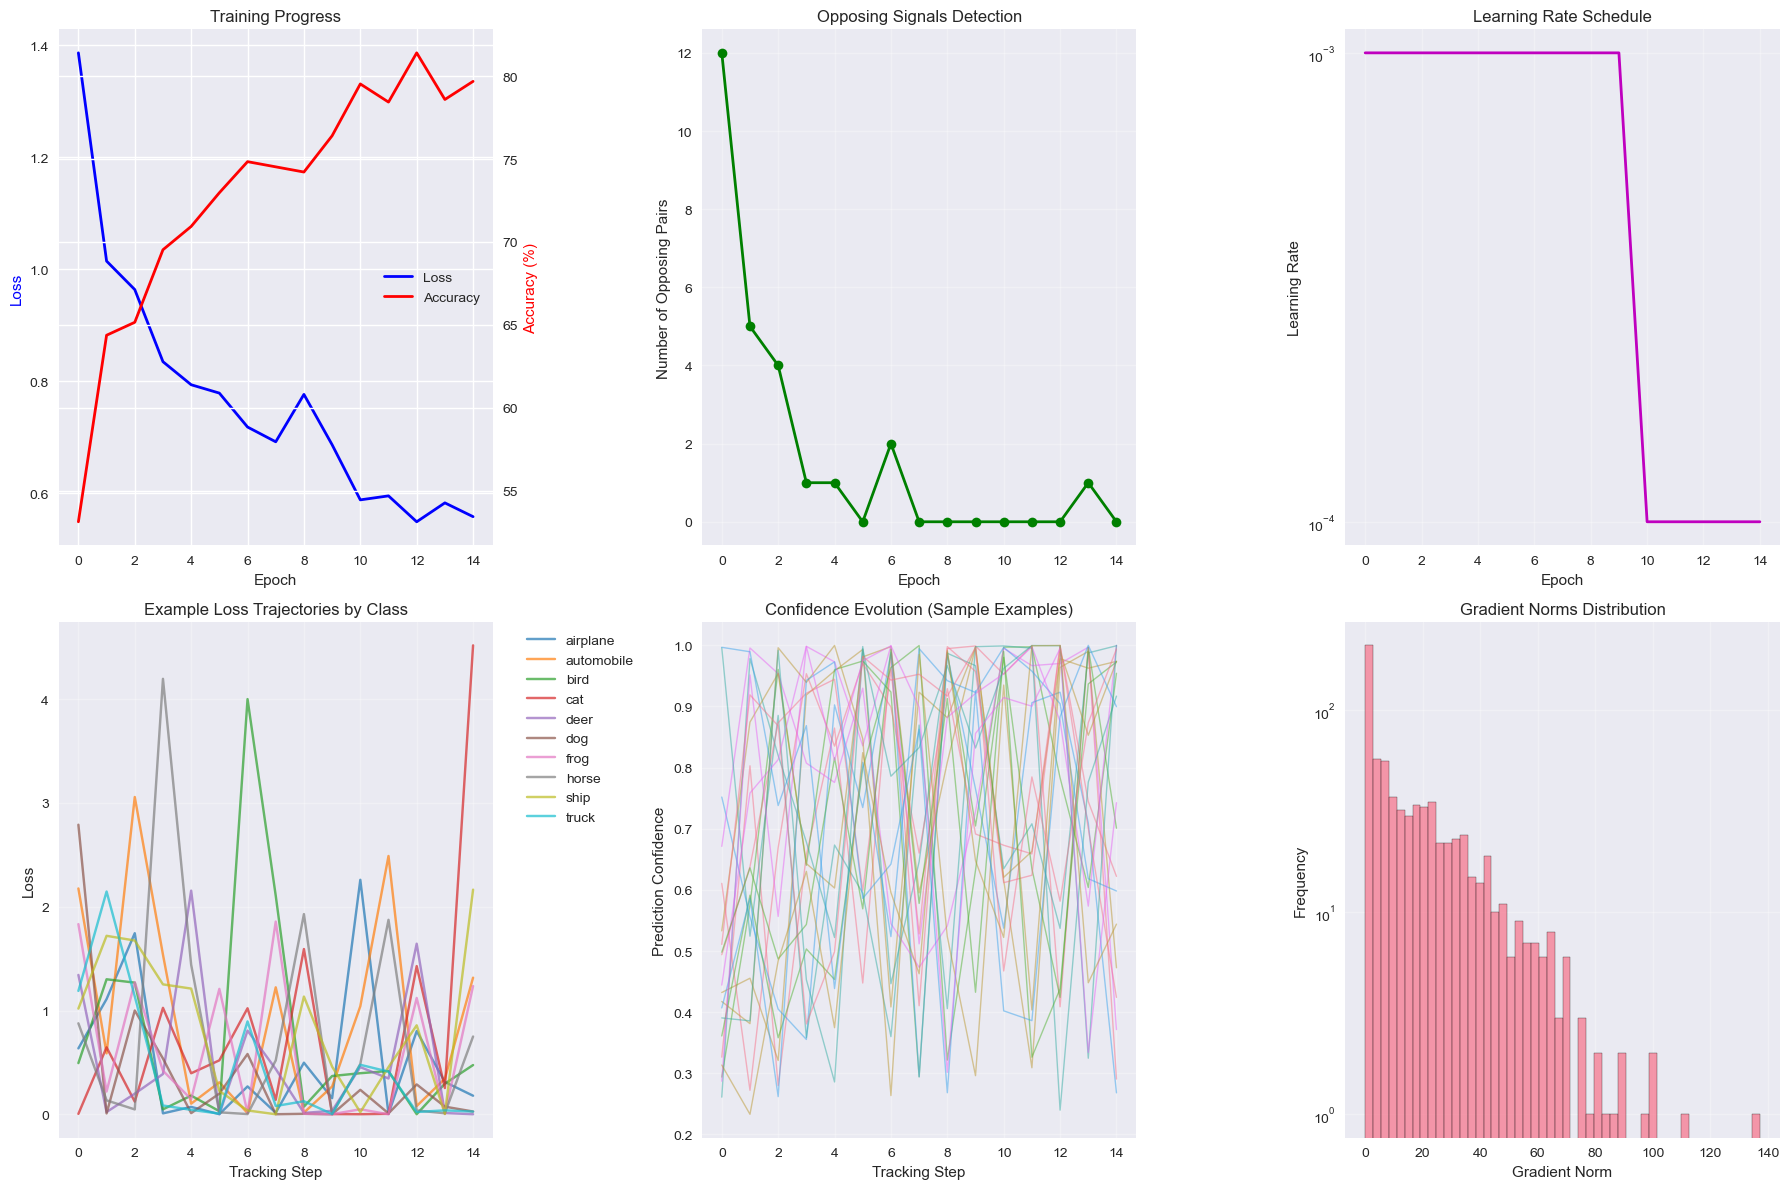

In [7]:
def analyze_training_dynamics(tracker):
    """Comprehensive analysis of training dynamics"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Training curves
    epochs = range(len(tracker.epoch_losses))
    
    ax1 = axes[0, 0]
    ax1_twin = ax1.twinx()
    
    line1 = ax1.plot(epochs, tracker.epoch_losses, 'b-', label='Loss', linewidth=2)
    line2 = ax1_twin.plot(epochs, tracker.epoch_accuracies, 'r-', label='Accuracy', linewidth=2)
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1_twin.set_ylabel('Accuracy (%)', color='r')
    ax1.set_title('Training Progress')
    
    # Combine legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    # 2. Opposing signals over time
    ax2 = axes[0, 1]
    ax2.plot(epochs, tracker.opposing_signals_history, 'g-', linewidth=2, marker='o')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Number of Opposing Pairs')
    ax2.set_title('Opposing Signals Detection')
    ax2.grid(True, alpha=0.3)
    
    # 3. Learning rate schedule
    ax3 = axes[0, 2]
    ax3.plot(epochs, tracker.learning_rates, 'm-', linewidth=2)
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_title('Learning Rate Schedule')
    ax3.set_yscale('log')
    ax3.grid(True, alpha=0.3)
    
    # 4. Example loss trajectories (sample)
    ax4 = axes[1, 0]
    
    # Plot trajectories for a few examples from each class
    class_colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for class_id in range(10):
        examples_in_class = [idx for idx, cls in tracker.example_to_class.items() if cls == class_id]
        
        if examples_in_class:
            # Plot first example from this class
            example_idx = examples_in_class[0]
            if example_idx in tracker.example_losses and tracker.example_losses[example_idx]:
                losses = tracker.example_losses[example_idx]
                ax4.plot(range(len(losses)), losses, 
                        color=class_colors[class_id], alpha=0.7,
                        label=class_names[class_id])
    
    ax4.set_xlabel('Tracking Step')
    ax4.set_ylabel('Loss')
    ax4.set_title('Example Loss Trajectories by Class')
    ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax4.grid(True, alpha=0.3)
    
    # 5. Confidence evolution
    ax5 = axes[1, 1]
    
    all_confidences = []
    for example_idx in list(tracker.example_confidences.keys())[:20]:  # Sample 20 examples
        confidences = tracker.example_confidences[example_idx]
        if confidences:
            ax5.plot(range(len(confidences)), confidences, alpha=0.5, linewidth=1)
            all_confidences.extend(confidences)
    
    ax5.set_xlabel('Tracking Step')
    ax5.set_ylabel('Prediction Confidence')
    ax5.set_title('Confidence Evolution (Sample Examples)')
    ax5.grid(True, alpha=0.3)
    
    # 6. Gradient norms distribution
    ax6 = axes[1, 2]
    
    all_grad_norms = []
    for grad_norms in tracker.example_gradients.values():
        all_grad_norms.extend(grad_norms)
    
    if all_grad_norms:
        ax6.hist(all_grad_norms, bins=50, alpha=0.7, edgecolor='black')
        ax6.set_xlabel('Gradient Norm')
        ax6.set_ylabel('Frequency')
        ax6.set_title('Gradient Norms Distribution')
        ax6.set_yscale('log')
        ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_dynamics_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# Run analysis
analyze_training_dynamics(tracker)

## 5. Opposing Signals Analysis

Found 26 opposing pairs


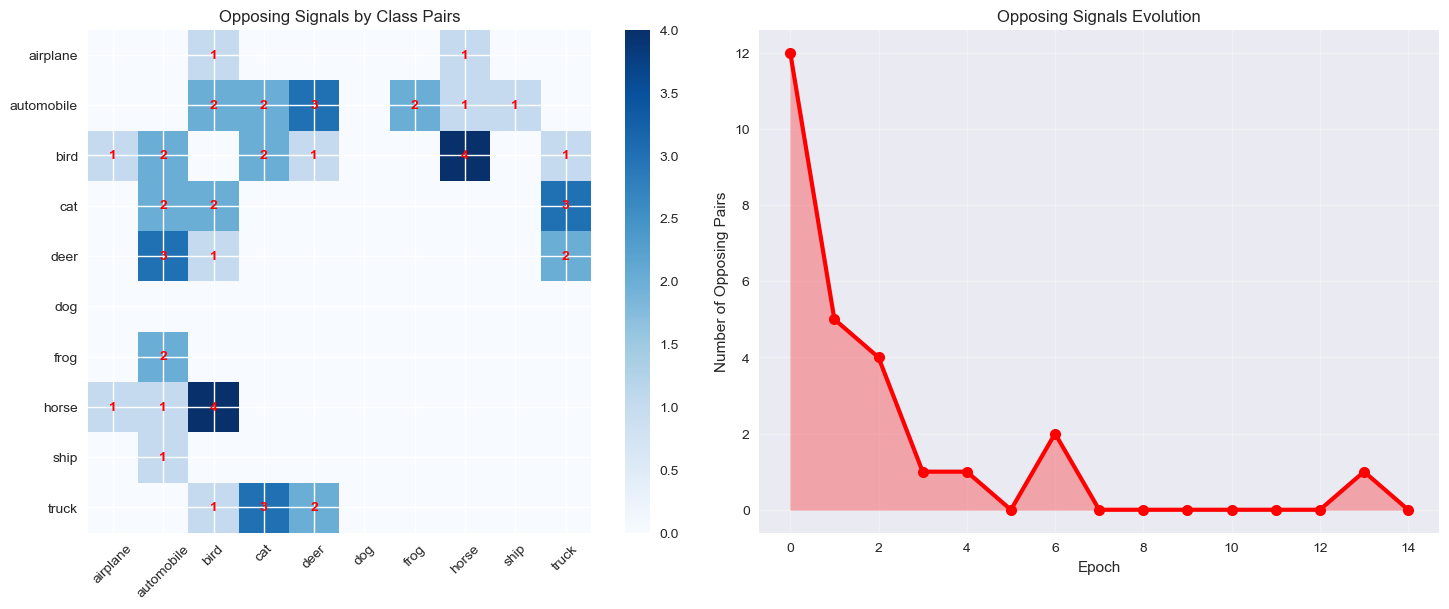


Opposing Signals Statistics:
Total opposing pairs: 26
Most common class pairs:
  bird vs horse: 4 pairs
  automobile vs deer: 3 pairs
  cat vs truck: 3 pairs
  automobile vs cat: 2 pairs
  deer vs truck: 2 pairs


In [8]:
def analyze_opposing_signals(tracker):
    """Detailed analysis of opposing signals"""
    
    if not tracker.opposing_pairs:
        print("No opposing pairs found. Consider lowering the opposing_threshold.")
        return
    
    print(f"Found {len(tracker.opposing_pairs)} opposing pairs")
    
    # Analyze class distribution in opposing pairs
    class_pair_counts = defaultdict(int)
    
    for idx1, idx2 in tracker.opposing_pairs:
        class1 = tracker.example_to_class.get(idx1, -1)
        class2 = tracker.example_to_class.get(idx2, -1)
        
        if class1 != -1 and class2 != -1:
            pair_key = tuple(sorted([class1, class2]))
            class_pair_counts[pair_key] += 1
    
    # Visualize opposing pairs
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Class pair matrix
    ax1 = axes[0]
    
    pair_matrix = np.zeros((10, 10))
    for (c1, c2), count in class_pair_counts.items():
        pair_matrix[c1, c2] = count
        pair_matrix[c2, c1] = count  # Symmetric
    
    im = ax1.imshow(pair_matrix, cmap='Blues')
    ax1.set_xticks(range(10))
    ax1.set_yticks(range(10))
    ax1.set_xticklabels(class_names, rotation=45)
    ax1.set_yticklabels(class_names)
    ax1.set_title('Opposing Signals by Class Pairs')
    
    # Add text annotations
    for i in range(10):
        for j in range(10):
            if pair_matrix[i, j] > 0:
                ax1.text(j, i, f'{int(pair_matrix[i, j])}', 
                        ha='center', va='center', color='red', fontweight='bold')
    
    plt.colorbar(im, ax=ax1)
    
    # 2. Opposing signals over time
    ax2 = axes[1]
    epochs = range(len(tracker.opposing_signals_history))
    ax2.plot(epochs, tracker.opposing_signals_history, 'r-', linewidth=3, marker='o', markersize=8)
    ax2.fill_between(epochs, tracker.opposing_signals_history, alpha=0.3, color='red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Number of Opposing Pairs')
    ax2.set_title('Opposing Signals Evolution')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('opposing_signals_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print detailed statistics
    print("\nOpposing Signals Statistics:")
    print(f"Total opposing pairs: {len(tracker.opposing_pairs)}")
    print(f"Most common class pairs:")
    
    sorted_pairs = sorted(class_pair_counts.items(), key=lambda x: x[1], reverse=True)
    for (c1, c2), count in sorted_pairs[:5]:
        print(f"  {class_names[c1]} vs {class_names[c2]}: {count} pairs")

# Run opposing signals analysis
analyze_opposing_signals(tracker)

## 6. Animated Visualizations

Animation saved to loss_trajectories.gif


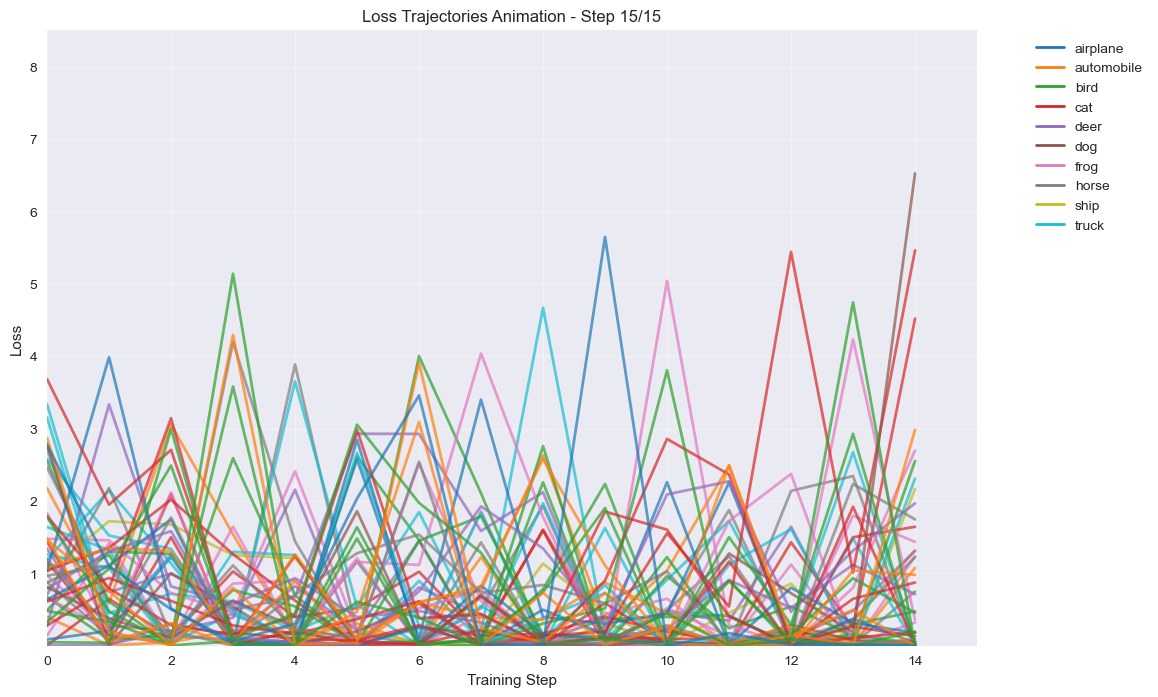

In [9]:
def create_loss_trajectory_animation(tracker, save_path='loss_trajectories.gif'):
    """Create animated visualization of loss trajectories"""
    
    if not SAVE_ANIMATIONS:
        print("Animation saving disabled. Set SAVE_ANIMATIONS=True to generate.")
        return
    
    # Prepare data
    examples_to_plot = []
    max_steps = 0
    
    # Get examples with sufficient data points
    for idx, losses in tracker.example_losses.items():
        if len(losses) >= 5:  # Minimum trajectory length
            examples_to_plot.append(idx)
            max_steps = max(max_steps, len(losses))
    
    examples_to_plot = examples_to_plot[:50]  # Limit for performance
    
    if not examples_to_plot:
        print("No examples with sufficient trajectory data for animation.")
        return
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Color mapping by class
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # Initialize lines
    lines = {}
    for idx in examples_to_plot:
        class_id = tracker.example_to_class.get(idx, 0)
        line, = ax.plot([], [], color=colors[class_id], alpha=0.7, linewidth=2)
        lines[idx] = line
    
    # Set up the plot
    all_losses = [loss for losses in tracker.example_losses.values() for loss in losses]
    ax.set_xlim(0, max_steps)
    ax.set_ylim(min(all_losses) * 0.9, max(all_losses) * 1.1)
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Loss')
    ax.set_title('Loss Trajectories Animation')
    ax.grid(True, alpha=0.3)
    
    # Add legend
    legend_lines = [plt.Line2D([0], [0], color=colors[i], linewidth=2) for i in range(10)]
    ax.legend(legend_lines, class_names, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    def animate(frame):
        for idx in examples_to_plot:
            losses = tracker.example_losses[idx]
            if frame < len(losses):
                x_data = list(range(frame + 1))
                y_data = losses[:frame + 1]
                lines[idx].set_data(x_data, y_data)
        
        # Update title with current step
        ax.set_title(f'Loss Trajectories Animation - Step {frame + 1}/{max_steps}')
        
        return list(lines.values())
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, animate, frames=max_steps, interval=200, blit=False, repeat=True
    )
    
    # Save animation
    try:
        anim.save(save_path, writer='pillow', fps=ANIMATION_FPS)
        print(f"Animation saved to {save_path}")
    except Exception as e:
        print(f"Failed to save animation: {e}")
    
    plt.show()
    return anim

# Create animation
if tracker.example_losses:
    anim = create_loss_trajectory_animation(tracker)
else:
    print("No loss trajectory data available for animation.")

## 7. Summary and Insights

In [10]:
def generate_summary_report(tracker):
    """Generate comprehensive summary report"""
    
    report = f"""
    ═══════════════════════════════════════════════════════════════
                          TRAINING DYNAMICS REPORT
    ═══════════════════════════════════════════════════════════════
    
    EXPERIMENT CONFIGURATION:
    • Examples tracked: {len(tracker.tracked_examples)}
    • Opposing threshold: {OPPOSING_THRESHOLD}
    • Dense sampling: {DENSE_SAMPLING}
    • Animation FPS: {ANIMATION_FPS}
    
    TRAINING RESULTS:
    • Total epochs: {len(tracker.epoch_losses)}
    • Final loss: {tracker.epoch_losses[-1]:.4f}
    • Final accuracy: {tracker.epoch_accuracies[-1]:.2f}%
    • Final learning rate: {tracker.learning_rates[-1]:.2e}
    
    OPPOSING SIGNALS ANALYSIS:
    • Total opposing pairs found: {len(tracker.opposing_pairs)}
    • Peak opposing signals: {max(tracker.opposing_signals_history) if tracker.opposing_signals_history else 0}
    • Average opposing signals per epoch: {np.mean(tracker.opposing_signals_history):.1f}
    
    LEARNING DYNAMICS:
    • Examples with complete trajectories: {sum(1 for losses in tracker.example_losses.values() if len(losses) >= 5)}
    • Average trajectory length: {np.mean([len(losses) for losses in tracker.example_losses.values()]):.1f}
    • Examples with gradient data: {len(tracker.example_gradients)}
    
    KEY FINDINGS:
    """
    
    # Add key findings based on analysis
    if tracker.opposing_pairs:
        report += f"\n    • Successfully detected opposing signals between examples from different classes"
        
        # Find most common opposing class pairs
        class_pair_counts = defaultdict(int)
        for idx1, idx2 in tracker.opposing_pairs:
            class1 = tracker.example_to_class.get(idx1, -1)
            class2 = tracker.example_to_class.get(idx2, -1)
            if class1 != -1 and class2 != -1:
                pair_key = tuple(sorted([class1, class2]))
                class_pair_counts[pair_key] += 1
        
        if class_pair_counts:
            top_pair = max(class_pair_counts.items(), key=lambda x: x[1])
            c1, c2 = top_pair[0]
            count = top_pair[1]
            report += f"\n    • Most opposing pair: {class_names[c1]} vs {class_names[c2]} ({count} pairs)"
    else:
        report += f"\n    • No opposing signals detected (consider lowering threshold)"
    
    # Learning progression analysis
    if len(tracker.epoch_accuracies) > 1:
        initial_acc = tracker.epoch_accuracies[0]
        final_acc = tracker.epoch_accuracies[-1]
        improvement = final_acc - initial_acc
        report += f"\n    • Accuracy improvement: {improvement:.2f}% (from {initial_acc:.2f}% to {final_acc:.2f}%)"
    
    # Loss dynamics
    if len(tracker.epoch_losses) > 1:
        initial_loss = tracker.epoch_losses[0]
        final_loss = tracker.epoch_losses[-1]
        loss_reduction = (initial_loss - final_loss) / initial_loss * 100
        report += f"\n    • Loss reduction: {loss_reduction:.1f}% (from {initial_loss:.4f} to {final_loss:.4f})"
    
    report += f"""
    
    RECOMMENDATIONS:
    • For more opposing signals, try lowering the opposing_threshold to 1.5
    • For better animations, enable DENSE_SAMPLING for more data points
    • Consider training for more epochs to observe longer-term dynamics
    • Experiment with different optimizers (SGD vs Adam) for different dynamics
    
    ═══════════════════════════════════════════════════════════════
                            END OF REPORT
    ═══════════════════════════════════════════════════════════════
    """
    
    print(report)
    
    # Save report to file
    with open('training_dynamics_report.txt', 'w') as f:
        f.write(report)
    
    print("\nDetailed report saved to 'training_dynamics_report.txt'")

# Generate final report
generate_summary_report(tracker)


    ═══════════════════════════════════════════════════════════════
                          TRAINING DYNAMICS REPORT
    ═══════════════════════════════════════════════════════════════

    EXPERIMENT CONFIGURATION:
    • Examples tracked: 100
    • Opposing threshold: 2.0
    • Dense sampling: True
    • Animation FPS: 10

    TRAINING RESULTS:
    • Total epochs: 15
    • Final loss: 0.5577
    • Final accuracy: 79.69%
    • Final learning rate: 1.00e-04

    OPPOSING SIGNALS ANALYSIS:
    • Total opposing pairs found: 26
    • Peak opposing signals: 12
    • Average opposing signals per epoch: 1.7

    LEARNING DYNAMICS:
    • Examples with complete trajectories: 100
    • Average trajectory length: 15.0
    • Examples with gradient data: 50

    KEY FINDINGS:
    
    • Successfully detected opposing signals between examples from different classes
    • Most opposing pair: bird vs horse (4 pairs)
    • Accuracy improvement: 26.56% (from 53.12% to 79.69%)
    • Loss reduction: 59

## 8. Export and Save Results

In [11]:
def save_results(tracker, model, filename='training_dynamics_results.pkl'):
    """Save all results for later analysis"""
    
    results = {
        'model_state_dict': model.state_dict(),
        'example_losses': dict(tracker.example_losses),
        'example_predictions': dict(tracker.example_predictions), 
        'example_confidences': dict(tracker.example_confidences),
        'example_gradients': dict(tracker.example_gradients),
        'opposing_pairs': list(tracker.opposing_pairs),
        'opposing_signals_history': tracker.opposing_signals_history,
        'epoch_losses': tracker.epoch_losses,
        'epoch_accuracies': tracker.epoch_accuracies,
        'learning_rates': tracker.learning_rates,
        'example_to_class': tracker.example_to_class,
        'tracked_examples': list(tracker.tracked_examples),
        'config': {
            'opposing_threshold': OPPOSING_THRESHOLD,
            'n_examples_track': N_EXAMPLES_TRACK,
            'dense_sampling': DENSE_SAMPLING,
            'animation_fps': ANIMATION_FPS
        },
        'timestamp': datetime.now().isoformat()
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(results, f)
    
    print(f"Results saved to {filename}")
    print(f"File size: {os.path.getsize(filename) / (1024*1024):.2f} MB")

def load_results(filename='training_dynamics_results.pkl'):
    """Load previously saved results"""
    
    with open(filename, 'rb') as f:
        results = pickle.load(f)
    
    print(f"Loaded results from {results['timestamp']}")
    print(f"Configuration: {results['config']}")
    
    return results

# Save current results
save_results(tracker, model)

print("\n" + "="*80)
print("TRAINING DYNAMICS ANALYSIS COMPLETE!")
print("Files generated:")
print("• training_dynamics_analysis.png - Main analysis plots")
print("• opposing_signals_analysis.png - Opposing signals visualization")
print("• loss_trajectories.gif - Animated loss trajectories (if enabled)")
print("• training_dynamics_report.txt - Detailed text report")
print("• training_dynamics_results.pkl - All data for further analysis")
print("="*80)

Results saved to training_dynamics_results.pkl
File size: 2.28 MB

TRAINING DYNAMICS ANALYSIS COMPLETE!
Files generated:
• training_dynamics_analysis.png - Main analysis plots
• opposing_signals_analysis.png - Opposing signals visualization
• loss_trajectories.gif - Animated loss trajectories (if enabled)
• training_dynamics_report.txt - Detailed text report
• training_dynamics_results.pkl - All data for further analysis
